# Using PauliPropagation.jl from Python via JuliaCall

This notebook demonstrates how to leverage the functionalities of the Julia package `PauliPropagation.jl` directly within a Python environment. We achieve this using the `juliacall` library, which acts as a bridge between Python and Julia.

**Goals:**
*   Show how to install and set up `juliacall`.
*   Replicate the "Basic Example" from `PauliPropagation.jl` using Python.
*   Illustrate data type conversions and calling Julia functions.
*   Provide examples of more advanced usage, such as parameter sweeps and visualizations.

In [10]:
# Install juliacall if you haven't already
# Uncomment the following line to install
# !pip install juliacall

### 2. Initializing Julia and `PauliPropagation.jl`

This cell performs the following crucial setup steps:
1.  **Imports `juliacall`**: It imports the `Main` object from `juliacall` and aliases it as `jl`. This `jl` object will be our primary interface to Julia.
2.  **Prints Julia Version**: It accesses and prints the version of the underlying Julia interpreter that `juliacall` is using.
3.  **Installs `PauliPropagation.jl`**: It uses `jl.seval()` to execute a Julia code block. This block checks if `PauliPropagation.jl` is already part of the current Julia project's dependencies. If not, it adds the package from the official Julia registry. This ensures the package is available for use.
4.  **Imports `PauliPropagation.jl` in Julia**: Finally, it executes `using PauliPropagation` within the Julia environment, making all exported functions and types from the package available through `jl.PauliPropagation`.

In [11]:
from juliacall import Main as jl

print("Julia version:", jl.VERSION)

# Install PauliPropagation if not already installed
# Note: This might take a while the first time
jl.seval("""
    using Pkg
    if !haskey(Pkg.project().dependencies, "PauliPropagation")
        Pkg.add("PauliPropagation")  # Install from registered package
    end
""")

jl.seval("using PauliPropagation")

Julia version: 1.10.9


### 2.1 Creating Aliases for Easier Access to Julia Functions

To make working with Julia functions more concise in Python, we'll create aliases for commonly used functions. This cell demonstrates two approaches:
1. **Module-level alias**: Creating a shorter name (`pp`) for the `PauliPropagation` module.
2. **Function-level aliases**: Exposing specific Julia functions directly to the Python namespace.

These aliases will make subsequent code more readable while maintaining access to Julia's functionality.

In [13]:
# Create more concise aliases for PauliPropagation functions
pp = jl.PauliPropagation  # Short alias for the whole module

# Import specific functions into the Python namespace
jl.seval("""
    # Make commonly used functions directly accessible
    paulistring = PauliPropagation.PauliString
    bricklayer = PauliPropagation.bricklayertopology
    propagate = PauliPropagation.propagate
    overlapzero = PauliPropagation.overlapwithzero
    countparams = PauliPropagation.countparameters
    tfitrotter = PauliPropagation.tfitrottercircuit
""")

print("PauliPropagation.jl module aliased as 'pp'")
print("Key functions also imported directly into Julia Main")

PauliPropagation.jl module aliased as 'pp'
Key functions also imported directly into Julia Main


### 3. Basic Example: Propagating a Pauli Observable

This cell replicates the core "Basic Example" from the `PauliPropagation.jl` documentation, demonstrating the fundamental workflow:

1.  **Define System Size (`nqubits`)**: Sets the number of qubits in the quantum system.
2.  **Create Observable**: Defines a `PauliString` observable using `pp.PauliString`. Here, it's a Z operator on qubit 16 in a 32-qubit system. `jl.Symbol("Z")` is used to pass the Pauli operator type as a Julia Symbol.
3.  **Define Circuit Topology**: Creates a `bricklayertopology` for the quantum circuit, which specifies how gates are arranged.
4.  **Create Quantum Circuit**: Defines a Transverse Field Ising Model (TFIM) Trotter circuit using `pp.tfitrottercircuit`.
5.  **Set Circuit Parameters**:
    *   `dt`: Defines a time step for the Trotter evolution.
    *   `parameters`: Creates a Julia array filled with the `dt` value, matching the number of parameters required by the circuit. `jl.fill()` is used here to correctly create a Julia array suitable for the `propagate` function.
6.  **Propagate Observable**: Evolves the `observable` through the `circuit` with the given `parameters` using `pp.propagate`. It also specifies truncation parameters (`max_weight` and `min_abs_coeff`) to manage the complexity of the resulting `PauliSum`.
7.  **Calculate Overlap**: Computes the expectation value of the propagated `PauliSum` with respect to the all-zeros state (`|0⟩⊗n`) using `pp.overlapwithzero`.
8.  **Print Results**: Outputs the initial observable, topology type, number of circuit parameters, number of terms in the resulting `PauliSum`, and the final overlap.

In [15]:
nqubits = 32

# Using our "pp" alias for cleaner code
observable = pp.PauliString(nqubits, jl.Symbol("Z"), 16)
print("Observable:", observable)

# Could also use jl.bricklayer from our aliased functions
topology = pp.bricklayertopology(nqubits, periodic=True)
print("Topology type:", type(topology))

nlayers = 32
circuit = pp.tfitrottercircuit(nqubits, nlayers, topology=topology)
print(f"Circuit has {pp.countparameters(circuit)} parameters")

dt = 0.1
parameters = jl.fill(dt, pp.countparameters(circuit))

max_weight = 6
min_abs_coeff = 1e-4
pauli_sum = pp.propagate(
    circuit, observable, parameters,
    max_weight=max_weight, min_abs_coeff=min_abs_coeff
)
print(f"Result has {jl.length(pauli_sum)} Pauli terms")

overlap = pp.overlapwithzero(pauli_sum)
print(f"Overlap with |0⟩⊗n: {overlap}")

Observable: PauliString(nqubits: 32, 1.0 * IIIIIIIIIIIIIIIZIIII...)
Topology type: <class 'juliacall.VectorValue'>
Circuit has 2048 parameters
Result has 1671 Pauli terms
Overlap with |0⟩⊗n: 0.15459672824142454


### 4. Visualizing the Observable's Evolution

This cell demonstrates how to visualize the evolution of the observable's expectation value over a range of time steps (`dt`).

1.  **Import Libraries**: Imports `matplotlib.pyplot` for plotting and `numpy` for numerical operations, particularly for creating an array of `dt` values.
2.  **Define Time Points (`dt_values`)**: Creates a `numpy` array of time step values using `np.linspace` to scan.
3.  **Iterate and Propagate**:
    *   It loops through each `dt_val` in `dt_values`.
    *   Inside the loop, it re-calculates the `parameters` array using `jl.fill(dt_val, ...)`.
    *   It calls `pp.propagate` for each `dt_val`.
    *   It calculates the `overlapwithzero`.
    *   The resulting overlap (converted to a Python `float`) is appended to the `results` list.
4.  **Plot Results**:
    *   Uses `matplotlib` to create a plot of the expectation value (overlap) against the time step (`dt_values`).
    *   Adds labels, a title, and a grid for better readability.
    *   `plt.show()` displays the plot.

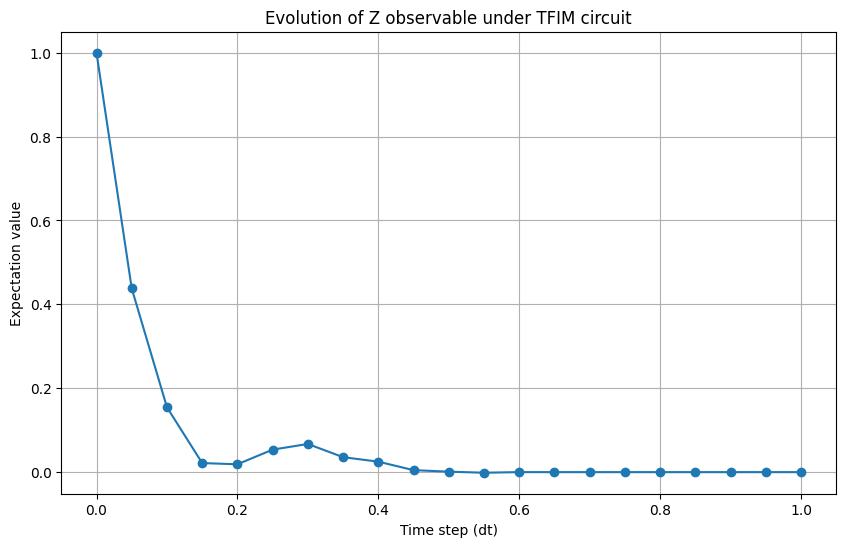

In [16]:
import matplotlib.pyplot as plt
import numpy as np

dt_values = np.linspace(0.0, 1.0, 21)

results = []

for dt_val in dt_values:
    parameters = jl.fill(dt_val, pp.countparameters(circuit))
    pauli_sum = pp.propagate(
        circuit, observable, parameters,
        max_weight=max_weight, min_abs_coeff=min_abs_coeff
    )
    overlap = pp.overlapwithzero(pauli_sum)
    results.append(float(overlap))

plt.figure(figsize=(10, 6))
plt.plot(dt_values, results, 'o-')
plt.xlabel('Time step (dt)')
plt.ylabel('Expectation value')
plt.title('Evolution of Z observable under TFIM circuit')
plt.grid(True)
plt.show()

### 5. Working with Julia Data Types and Functions from Python

This cell showcases several ways to interact with Julia's data types and functionalities from Python:

1.  **Convert Julia Array to Python NumPy Array**:
    *   `jl.rand(10)`: Creates a Julia array of 10 random numbers.
    *   `np.array(julia_array)`: Converts this Julia array into a Python NumPy array.
    *   The types of both arrays are printed to demonstrate the conversion.
2.  **Define and Call a Custom Julia Function**:
    *   `jl.seval("""...""")`: Defines a new Julia function named `count_nonzero_terms` directly within the Julia runtime. This function takes a `pauli_sum` (expected to be a `PauliSum` object) and returns the number of terms in it using `length(pauli_sum)`.
    *   `jl.count_nonzero_terms(pauli_sum)`: Calls this newly defined Julia function from Python, passing the `pauli_sum` object obtained from the previous propagation.
    *   The result is converted to a Python `int` and printed.
3.  **Access Julia Documentation**:
    *   `jl.seval("@doc PauliPropagation.propagate")`: Executes Julia's macro `@doc` to retrieve the documentation string for the `PauliPropagation.propagate` function.
    *   The fetched documentation text is printed.

In [17]:
julia_array = jl.rand(10)
python_array = np.array(julia_array)
print("Julia array type:", type(julia_array))
print("Python array type:", type(python_array))

jl.seval("""
function count_nonzero_terms(pauli_sum)
    return length(pauli_sum)
end
""")

num_terms = jl.count_nonzero_terms(pauli_sum)
print(f"Number of non-zero Pauli terms: {int(num_terms)}")

help_text = jl.seval("@doc PauliPropagation.propagate")
print("Documentation for propagate function:")
print(help_text)

Julia array type: <class 'juliacall.VectorValue'>
Python array type: <class 'numpy.ndarray'>
Number of non-zero Pauli terms: 0
Documentation for propagate function:
```
propagate(circ, pstr::PauliString, thetas=nothing; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, kwargs...)
```

Propagate a `PauliString` through the circuit `circ` in the Heisenberg picture.  This means that the circuit is applied to the Pauli string in reverse order, and the action of each gate is its conjugate action. Parameters for the parametrized gates in `circ` are given by `thetas`, and need to be passed as if the circuit was applied as written in the Schrödinger picture. If thetas are not passed, the circuit must contain only non-parametrized `StaticGates`. Default truncations are `max_weight`, `min_abs_coeff`, `max_freq`, and `max_sins`. `max_freq`, and `max_sins` will lead to automatic conversion if the coefficients are not already wrapped in suitable `PathProperti

### 6. Advanced Example: Comparing Different Truncation Settings

This cell extends the visualization by comparing the observable's evolution under different `max_weight` truncation settings.

1.  **Define Settings**:
    *   `weight_settings`: A list of different `max_weight` values to test.
    *   `colors`: A list of colors for plotting, corresponding to each `max_weight`.
2.  **Outer Loop (Iterate `max_weight`)**:
    *   The code iterates through each `max_w` in `weight_settings`.
3.  **Inner Loop (Iterate `dt_values`)**:
    *   For each `max_w`, it iterates through the `dt_values` (time steps) similar to Cell 4.
    *   `parameters` are created using `jl.fill(dt_val, ...)`.
    *   `pp.propagate` is called with the current `max_w`.
    *   **Print Term Count**: For the first `dt_val` in each `max_w` iteration, it prints the number of Pauli terms in the `pauli_sum` using `jl.length(pauli_sum)`. This gives an idea of how `max_weight` affects the complexity.
    *   The `overlap` is calculated and stored.
4.  **Plotting**:
    *   For each `max_w`, `plt.plot` is called to add a line to the graph, using a different color and label.
5.  **Finalize Plot**: Adds labels, title, legend (to distinguish lines for different `max_w`), and a grid. `plt.show()` displays the comparison plot.

Max weight 2: 1 Pauli terms
Max weight 4: 1 Pauli terms
Max weight 6: 1 Pauli terms
Max weight 8: 1 Pauli terms


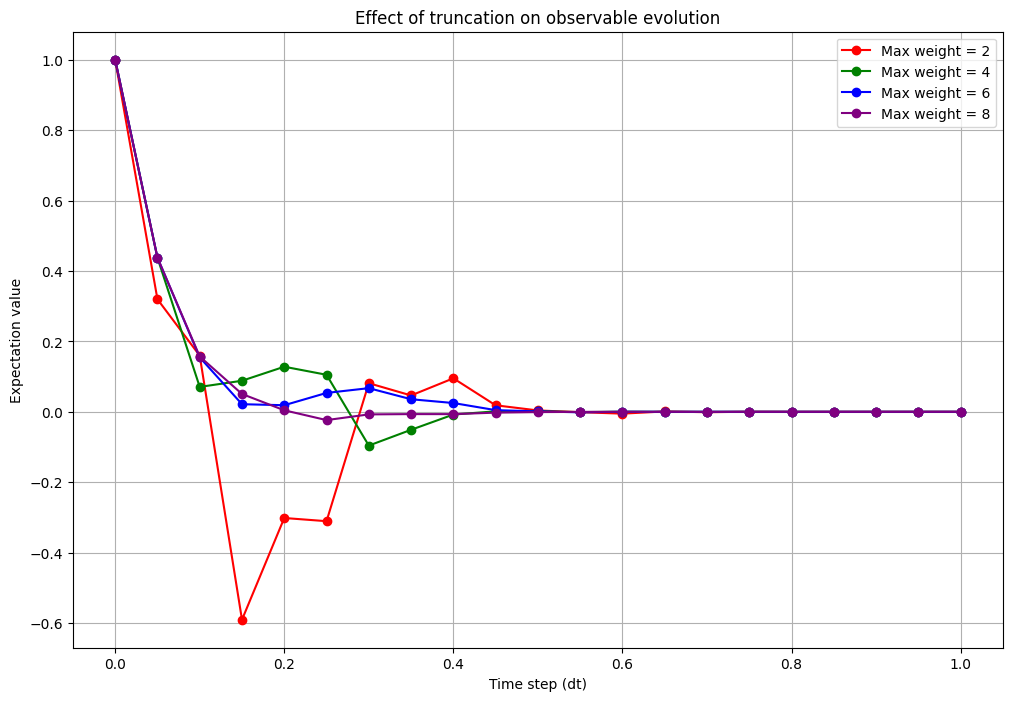

In [18]:
weight_settings = [2, 4, 6, 8]
colors = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 8))

for idx, max_w in enumerate(weight_settings):
    results = []
    for dt_val in dt_values:
        parameters = jl.fill(dt_val, pp.countparameters(circuit))
        pauli_sum = pp.propagate(
            circuit, observable, parameters,
            max_weight=max_w, min_abs_coeff=min_abs_coeff
        )

        if dt_val == dt_values[0]:
            term_count = jl.length(pauli_sum)
            print(f"Max weight {max_w}: {int(term_count)} Pauli terms")

        overlap = pp.overlapwithzero(pauli_sum)
        results.append(float(overlap))

    plt.plot(dt_values, results, 'o-', color=colors[idx], label=f'Max weight = {max_w}')

plt.xlabel('Time step (dt)')
plt.ylabel('Expectation value')
plt.title('Effect of truncation on observable evolution')
plt.legend()
plt.grid(True)
plt.show()

### 7. Visualizing Evolution Over Circuit Layers

This example demonstrates a more physically meaningful visualization: how the observable evolves as the circuit depth increases. Instead of varying the time step parameter (`dt`), we:
1. Fix `dt` to a constant value (0.1)
2. Create circuits with varying numbers of layers
3. Plot the expectation value against the circuit depth

This approach provides insight into how the quantum state evolves in time as more gates are applied, which is often more intuitive for understanding quantum dynamics.

Visualizing evolution over circuit layers...
Layers: 0, Overlap: 1.0
Layers: 2, Overlap: 0.9801659131709816
Layers: 4, Overlap: 0.924788980914988
Layers: 6, Overlap: 0.8438425769455423
Layers: 8, Overlap: 0.7502800814528446
Layers: 10, Overlap: 0.656421470955794
Layers: 12, Overlap: 0.5711589805879755
Layers: 14, Overlap: 0.49816028068788726
Layers: 16, Overlap: 0.4371388574779703
Layers: 18, Overlap: 0.3861723335935846
Layers: 20, Overlap: 0.34193165194823827
Layers: 22, Overlap: 0.302003648861224
Layers: 24, Overlap: 0.2659393167673705
Layers: 26, Overlap: 0.23384440510904095
Layers: 28, Overlap: 0.20473668440810214
Layers: 30, Overlap: 0.1781840895377
Layers: 32, Overlap: 0.15459672824142454
Layers: 34, Overlap: 0.1335143945874481
Layers: 36, Overlap: 0.11412308563741819
Layers: 38, Overlap: 0.09548381912040674
Layers: 40, Overlap: 0.07754069055047479
Layers: 42, Overlap: 0.0606991925083803
Layers: 44, Overlap: 0.0463902854101824
Layers: 46, Overlap: 0.034298007655765975
Layers: 48,

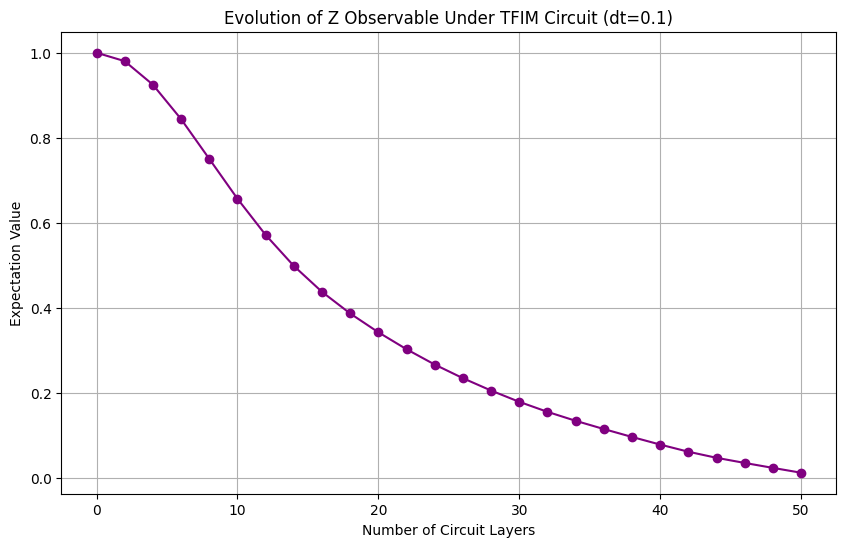

In [19]:
print("Visualizing evolution over circuit layers...")

# Fixed dt value
dt = 0.1


max_layers = 50
layer_values = list(range(0, max_layers+1, 2))  # Step by 2 to reduce computation time
layer_results = []

for num_layers in layer_values:

    layer_circuit = pp.tfitrottercircuit(nqubits, num_layers, topology=topology)


    layer_params = jl.fill(dt, pp.countparameters(layer_circuit))

    if num_layers == 0:

        overlap = pp.overlapwithzero(observable)
    else:
        # Propagate the observable through the circuit
        propagated = pp.propagate(
            layer_circuit, observable, layer_params,
            max_weight=max_weight, min_abs_coeff=min_abs_coeff
        )
        overlap = pp.overlapwithzero(propagated)

    layer_results.append(float(overlap))
    print(f"Layers: {num_layers}, Overlap: {overlap}")


plt.figure(figsize=(10, 6))
plt.plot(layer_values, layer_results, 'o-', color='purple')
plt.xlabel('Number of Circuit Layers')
plt.ylabel('Expectation Value')
plt.title(f'Evolution of Z Observable Under TFIM Circuit (dt={dt})')
plt.grid(True)
plt.show()

### 8. Comparing Truncation Effects on Layer-wise Evolution

We can combine our previous examples to visualize how different truncation settings affect the evolution over circuit layers. This provides insight into the trade-off between accuracy and computational complexity as the circuit depth increases.

Max weight 2, Layers 3: 6 Pauli terms
Max weight 4, Layers 3: 12 Pauli terms
Max weight 6, Layers 3: 12 Pauli terms
Max weight 8, Layers 3: 12 Pauli terms


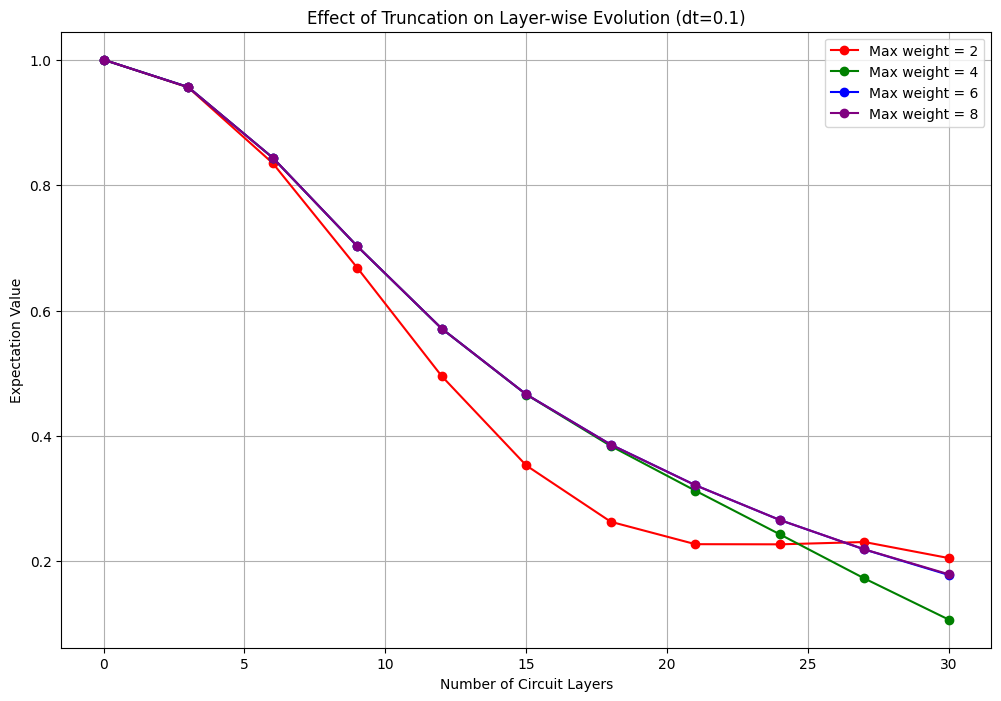

In [20]:
weight_settings = [2, 4, 6, 8]
colors = ['red', 'green', 'blue', 'purple']
dt = 0.1

# Fewer layers and bigger steps for faster computation
max_layers = 30
layer_values = list(range(0, max_layers+1, 3))

plt.figure(figsize=(12, 8))

for idx, max_w in enumerate(weight_settings):
    layer_results = []

    for num_layers in layer_values:

        layer_circuit = pp.tfitrottercircuit(nqubits, num_layers, topology=topology)

        # Create parameters filled with fixed dt
        layer_params = jl.fill(dt, pp.countparameters(layer_circuit))

        if num_layers == 0:
            # For 0 layers, just use the original observable
            overlap = pp.overlapwithzero(observable)
        else:
            # Propagate the observable through the circuit
            propagated = pp.propagate(
                layer_circuit, observable, layer_params,
                max_weight=max_w, min_abs_coeff=min_abs_coeff
            )
            overlap = pp.overlapwithzero(propagated)

        layer_results.append(float(overlap))


        if num_layers == layer_values[1]:  # First non-zero layer
            term_count = jl.length(propagated if num_layers > 0 else observable)
            print(f"Max weight {max_w}, Layers {num_layers}: {int(term_count)} Pauli terms")

    plt.plot(layer_values, layer_results, 'o-', color=colors[idx],
             label=f'Max weight = {max_w}')

plt.xlabel('Number of Circuit Layers')
plt.ylabel('Expectation Value')
plt.title(f'Effect of Truncation on Layer-wise Evolution (dt={dt})')
plt.legend()
plt.grid(True)
plt.show()